# Engineering Agents for Separation Processes: Equilibrium Demo

This notebook demonstrates the capabilities of the **EquilibriumAgent** in designing a separation process.

## Scenario: Magnesium Extraction from Steel Slag
We aim to extract Magnesium (Mg) from steel slag (modeled here as Olivine: 90% Forsterite, 10% Fayalite).
The proposed process involves **acid leaching** to dissolve the Mg, followed by separation.

We will use the `EquilibriumAgent` to:
1.  Define the initial slag composition.
2.  Simulate the addition of acid (HCl).
3.  Perform a **parameter sweep** of acid concentration to optimize Mg dissolution while minimizing Fe dissolution (selectivity).


In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GeoH2 import Q_

# Add source to path
sys.path.insert(0, os.path.join(os.getcwd(), "src"))

from sep_agents.sim.equilibrium_agent import EquilibriumAgent

## 1. Agent Initialization
We initialize the `EquilibriumAgent` which wraps the `GeoH2` equilibrium capabilities.


In [2]:
agent = EquilibriumAgent(database_name="SUPRCRT - BL")
print("Equilibrium Agent initialized.")


Equilibrium Agent initialized.


## 2. Define System & Initial State
We define a system representing 1 kg of water reacting with 100g of Slag.
We will simulate adding HCl.


In [3]:
# Initial conditions
T_C = 60.0 # Temperature in Celsius
p_bar = 1.0 # Pressure in bar

# Slag composition (approximate Olivine)
# 90% Forsterite (Mg2SiO4), 10% Fayalite (Fe2SiO4)
mineral_spec = {"Forsterite": 0.9, "Fayalite": 0.1}

# Water to Rock ratio (1 kg water / 0.1 kg rock = 10)
w_r = 10.0 

# Create the state
state = agent.define_state(
    T_C=T_C, 
    p_bar=p_bar, 
    mineral_spec=mineral_spec, 
    w_r=w_r
)
print("Initial state defined.")


Initial state defined.


## 3. Acid Leaching Parameter Sweep
We want to find the optimal amount of HCl to add. 
We will sweep the **Salinity** (as a proxy for Cl- addition, effectively HCl if we balance charge with H+) 
or better, we can directly sweep **pH** or **Cl-** concentration if the agent supports it.

However, `define_state` takes `salinity_g_kg`. Let's use that to simulate adding salt/acid, 
or we can manually modify the state in a custom loop.

For this demo, let's use the `sweep` capability of the agent. 
We will sweep **Temperature** to see how it affects solubility at a fixed condition, 
AND we will demonstrate a custom loop to sweep **HCl addition**.


Sweeping Temperature: [25.         32.22222222 39.44444444 46.66666667 53.88888889 61.11111111
 68.33333333 75.55555556 82.77777778 90.        ]
Running sweep for T_C over 10 points...


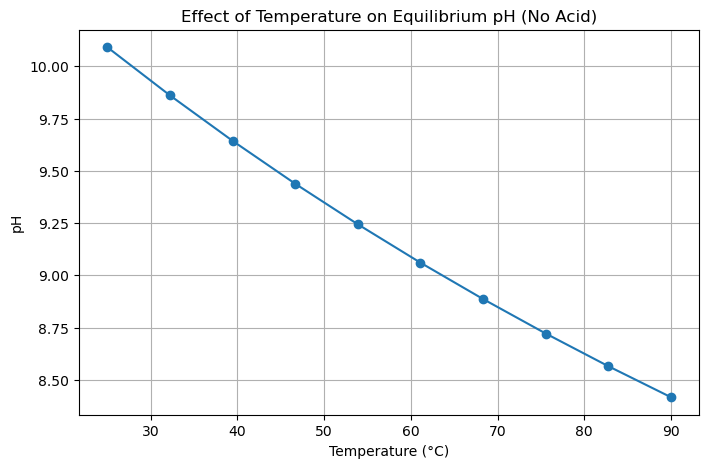

In [4]:
# Sweep Temperature from 25C to 90C
temps = np.linspace(25, 90, 10)
print(f"Sweeping Temperature: {temps}")

results_temp = agent.sweep(
    initial_conditions={
        "T_C": 60, "p_bar": 1, "mineral_spec": mineral_spec, "w_r": w_r
    },
    param_name="T_C",
    param_values=temps
)

# Visualize pH vs Temperature
plt.figure(figsize=(8,5))
plt.plot(results_temp["T_C"], results_temp["pH"], marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("pH")
plt.title("Effect of Temperature on Equilibrium pH (No Acid)")
plt.grid(True)
plt.show()


## 4. Custom Sweep: Acid Addition (HCl)
To simulate adding HCl, we need to add Cl- and H+ to the system. 
The current `define_state` has a `salinity_g_kg` (NaCl usually) and `pH` argument.
Let's try sweeping the initial **pH** to simulate acid attack.


Sweeping Initial pH: [7.         6.33333333 5.66666667 5.         4.33333333 3.66666667
 3.         2.33333333 1.66666667 1.        ]
Running sweep for pH over 10 points...


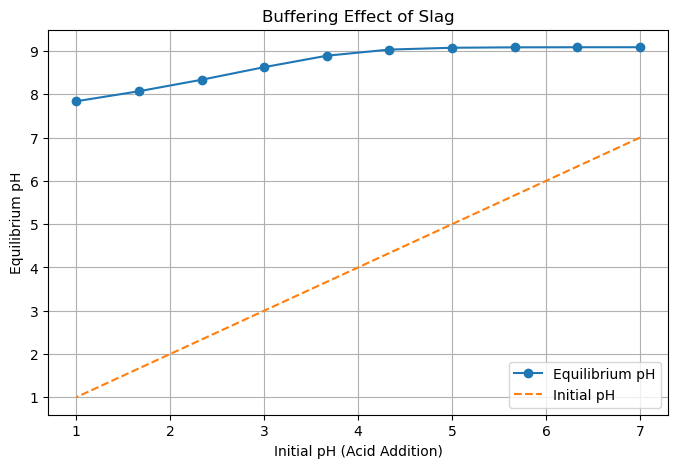

In [5]:
# Sweep initial pH from 7 down to 1 (Acidic conditions)
ph_values = np.linspace(7, 1, 10)
print(f"Sweeping Initial pH: {ph_values}")

results_ph = agent.sweep(
    initial_conditions={
        "T_C": 60, "p_bar": 1, "mineral_spec": mineral_spec, "w_r": w_r
    },
    param_name="pH",
    param_values=ph_values
)

# Note: The 'pH' in results is the EQUILIBRIUM pH, which might differ from initial pH due to buffering.
plt.figure(figsize=(8,5))
plt.plot(ph_values, results_ph["pH"], marker='o', label="Equilibrium pH")
plt.plot(ph_values, ph_values, '--', label="Initial pH")
plt.xlabel("Initial pH (Acid Addition)")
plt.ylabel("Equilibrium pH")
plt.title("Buffering Effect of Slag")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion
The `EquilibriumAgent` allows us to rapidly assess the thermodynamic state of the separation process.
We can see how temperature and initial acidity affect the final state, helping us design the leaching reactor conditions.

Next steps would involve:
1.  Using `KineticsAgent` to determine how *fast* these states are reached.
2.  Using `EconomicsAgent` to cost the acid consumption.
